# 04 — Risk Modeling (Classification)

## Objective
Build a **risk calculator** that estimates the probability that a wine will have **low technical quality** based on its chemical composition.

The risk model is designed to **minimize false negatives** (i.e., avoid missing low-quality wines).


In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve
)

import matplotlib.pyplot as plt


## 1. Data Loading

We use the **Wine Quality (chemical composition)** dataset.  
This notebook assumes the dataset has already been cleaned according to the EDA notebook.


In [5]:
import pandas as pd
import numpy as np
import yaml
from pathlib import Path

# Load project configuration
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

RAW_PATH = Path("..") / config["paths"]["raw_data"]
WINE_QUALITY_FILE = config["files"]["wine_quality"]

raw_file_path = RAW_PATH / WINE_QUALITY_FILE
raw_file_path


WindowsPath('../data/raw/WineQT.csv')

In [6]:
# Read the dataset (supports common formats)
suffix = raw_file_path.suffix.lower()

if suffix == ".csv":
    wine_quality = pd.read_csv(raw_file_path)
elif suffix in [".xlsx", ".xls"]:
    wine_quality = pd.read_excel(raw_file_path)
else:
    raise ValueError(f"Unsupported file format: {suffix}")

wine_quality.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [7]:
print("Shape:", wine_quality.shape)
display(wine_quality.dtypes)
display(wine_quality.isna().sum().sort_values(ascending=False).head(10))


Shape: (1143, 13)


fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Id                        int64
dtype: object

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
dtype: int64

### Notes
- This notebook assumes the Wine Quality dataset includes a `quality` column as the target for both regression (technical quality) and risk classification (low quality risk).
- Any cleaning steps should be consistent with `01_wine_quality_EDA.ipynb`. If cleaning is performed here, it should be minimal and documented.


## 2. Risk Definition

### Risk event (target)
We define **High Risk (1)** as a wine likely to receive a **low quality score**:

- `risk = 1` if `quality <= 5`
- `risk = 0` if `quality > 5`

### Why this threshold?
- The `quality` score is ordinal (typically 3–8).
- Scores of **6** are commonly treated as "acceptable/average", while **5 or lower** indicates a below-average outcome.
- This threshold yields a practical number of positive cases for supervised classification.

### Cost asymmetry
We prioritize **minimizing false negatives**:
- Missing a low-quality wine is more costly than flagging a wine that would have been acceptable.

### Primary metric
- **Recall (High Risk class)** is the primary optimization metric.


In [8]:
RISK_THRESHOLD = 5
wine_quality = wine_quality.copy()
wine_quality["risk"] = (wine_quality["quality"] <= RISK_THRESHOLD).astype(int)

risk_counts = wine_quality["risk"].value_counts()
risk_rate = wine_quality["risk"].mean()

print("Risk class counts:")
print(risk_counts)
print(f"\nHigh-risk rate: {risk_rate:.3%}")


Risk class counts:
risk
0    621
1    522
Name: count, dtype: int64

High-risk rate: 45.669%


## 3. Feature Set - Train/Test Split 

We use the standard chemical features available in the dataset.

Notes:
- All features are numeric, so **no encoders** are required.
- Scaling is required for logistic regression.


In [50]:
feature_cols = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol"
]

from sklearn.model_selection import train_test_split

# Target
y = wine_quality["risk"]
X = wine_quality[feature_cols]

# 1) Keep test as final holdout
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 2) Create validation split from train only (for threshold tuning)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.25,          # 0.25 of 0.80 = 0.20
    random_state=42,
    stratify=y_train_full
)

print("Train risk rate:", y_train.mean())
print("Val risk rate:", y_val.mean())
print("Test risk rate:", y_test.mean())



Train risk rate: 0.4569343065693431
Val risk rate: 0.45414847161572053
Test risk rate: 0.4585152838427948


## 4. Baseline (Dummy Classifier)

We start with a simple baseline to establish a lower bound.
A dummy model may achieve decent accuracy but typically fails on recall for the High Risk class.


In [51]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report

dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_val)

print("Confusion matrix (Dummy) — Validation:")
print(confusion_matrix(y_val, y_pred_dummy))
print("\nClassification report (Dummy) — Validation:")
print(classification_report(y_val, y_pred_dummy, digits=3))



Confusion matrix (Dummy) — Validation:
[[125   0]
 [104   0]]

Classification report (Dummy) — Validation:
              precision    recall  f1-score   support

           0      0.546     1.000     0.706       125
           1      0.000     0.000     0.000       104

    accuracy                          0.546       229
   macro avg      0.273     0.500     0.353       229
weighted avg      0.298     0.546     0.385       229



C:\Users\Marta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Marta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Marta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 5. Logistic Regression (Recall-Oriented)

We train a Logistic Regression model using:
- **Standard scaling**
- **Class weights** to counter imbalance
- Probability outputs to enable **threshold tuning** for high recall


In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score

logreg_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ))
])

logreg_pipe.fit(X_train, y_train)

y_prob_val = logreg_pipe.predict_proba(X_val)[:, 1]
y_pred_default_val = (y_prob_val >= 0.5).astype(int)

print("Confusion matrix (LogReg, threshold=0.5) — Validation:")
print(confusion_matrix(y_val, y_pred_default_val))
print("\nClassification report (LogReg, threshold=0.5) — Validation:")
print(classification_report(y_val, y_pred_default_val, digits=3))

print("\nROC-AUC (val):", roc_auc_score(y_val, y_prob_val))
print("PR-AUC (val):", average_precision_score(y_val, y_prob_val))



Confusion matrix (LogReg, threshold=0.5) — Validation:
[[95 30]
 [20 84]]

Classification report (LogReg, threshold=0.5) — Validation:
              precision    recall  f1-score   support

           0      0.826     0.760     0.792       125
           1      0.737     0.808     0.771       104

    accuracy                          0.782       229
   macro avg      0.781     0.784     0.781       229
weighted avg      0.786     0.782     0.782       229


ROC-AUC (val): 0.8330000000000001
PR-AUC (val): 0.7753518682542482


## 6. Threshold Tuning (Minimize False Negatives)

We do not assume a 0.5 threshold.
Instead, we choose a threshold that achieves a **target recall** for the High Risk class.

We will:
1) compute precision-recall curve
2) select the lowest threshold that meets a target recall (e.g., 0.90)
3) report confusion matrix and metrics at that threshold


In [53]:
def threshold_for_target_recall(y_true, y_prob, target_recall=0.90):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    # thresholds has length n-1; precision/recall length n
    # We'll align by using recall[:-1] with thresholds
    recall_thr = recall[:-1]
    precision_thr = precision[:-1]

    valid = np.where(recall_thr >= target_recall)[0]
    if len(valid) == 0:
        return None, None, None

    # choose the lowest threshold that still meets target recall
    idx = valid[-1]
    return thresholds[idx], precision_thr[idx], recall_thr[idx]


TARGET_RECALL = 0.90

best_thr, prec_at_thr, rec_at_thr = threshold_for_target_recall(
    y_val,
    y_prob_val,
    target_recall=TARGET_RECALL
)

print("Selected threshold (from validation):", best_thr)
print("Precision at threshold (val):", prec_at_thr)
print("Recall at threshold (val):", rec_at_thr)



Selected threshold (from validation): 0.3402229712419155
Precision at threshold (val): 0.5987261146496815
Recall at threshold (val): 0.9038461538461539


In [54]:
y_prob_test = logreg_pipe.predict_proba(X_test)[:, 1]


In [55]:
if best_thr is None:
    print("No threshold meets the target recall. Consider lowering TARGET_RECALL.")
else:
    y_pred_test = (y_prob_test >= best_thr).astype(int)

    print("Confusion matrix (LogReg, tuned threshold) — Test:")
    print(confusion_matrix(y_test, y_pred_test))
    print("\nClassification report (LogReg, tuned threshold) — Test:")
    print(classification_report(y_test, y_pred_test, digits=3))


Confusion matrix (LogReg, tuned threshold) — Test:
[[74 50]
 [14 91]]

Classification report (LogReg, tuned threshold) — Test:
              precision    recall  f1-score   support

           0      0.841     0.597     0.698       124
           1      0.645     0.867     0.740       105

    accuracy                          0.721       229
   macro avg      0.743     0.732     0.719       229
weighted avg      0.751     0.721     0.717       229



In [56]:
print("ROC-AUC (test):", roc_auc_score(y_test, y_prob_test))
print("PR-AUC (test):", average_precision_score(y_test, y_prob_test))


ROC-AUC (test): 0.8194316436251919
PR-AUC (test): 0.7820915845155433


## 7. Precision–Recall Curve

This plot visualizes the trade-off when prioritizing recall (minimizing false negatives).


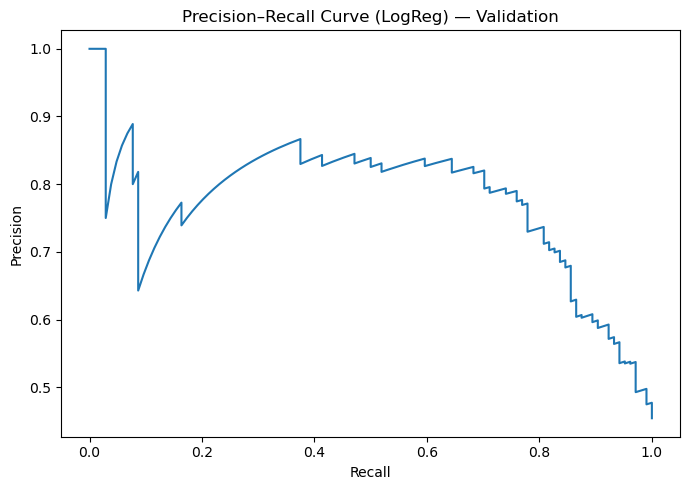

In [57]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_val, y_prob_val)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (LogReg) — Validation")
plt.tight_layout()
plt.show()


## 8. Save Artifacts (Model + Scaler)

For the final risk calculator, we will save:
- the fitted scaler
- the trained model
- the chosen decision threshold

Note: since we used a Pipeline, the scaler and model are inside it.
We can save the full pipeline (recommended) and also save scaler/model separately if required.


In [58]:
import joblib
from pathlib import Path

# Base directory: project root (one level above notebooks/)
BASE_DIR = Path("..")

MODELS_DIR = BASE_DIR / "models"
SCALERS_DIR = BASE_DIR / "scalers"
ENCODERS_DIR = BASE_DIR / "encoders"

MODELS_DIR.mkdir(exist_ok=True)
SCALERS_DIR.mkdir(exist_ok=True)
ENCODERS_DIR.mkdir(exist_ok=True)  # kept for structure consistency

# Save full pipeline (recommended)
joblib.dump(logreg_pipe, MODELS_DIR / "logreg_risk_pipeline.joblib")

# Save threshold metadata
joblib.dump(
    {
        "risk_definition": "quality <= 5",
        "decision_threshold": best_thr,
        "target_recall": TARGET_RECALL
    },
    MODELS_DIR / "risk_thresholds.joblib"
)

# Optional: save scaler and model separately (if required)
scaler_fitted = logreg_pipe.named_steps["scaler"]
model_fitted = logreg_pipe.named_steps["model"]

joblib.dump(scaler_fitted, SCALERS_DIR / "standard_scaler_risk.joblib")
joblib.dump(model_fitted, MODELS_DIR / "logreg_risk_model.joblib")



['..\\models\\logreg_risk_model.joblib']

## 9. Summary (So Far)

- Defined **risk** as `quality <= 5`
- Prioritized **minimizing false negatives**
- Built:
  - Dummy baseline
  - Logistic Regression with class weighting
- Tuned the decision threshold to achieve high recall
- Saved artifacts for the risk calculator


## 10. Model Interpretability (Logistic Regression)

To make the risk calculator interpretable, we analyze the **coefficients** of the Logistic Regression model.

Because the model is linear in the log-odds space:
- A **positive coefficient** increases the probability of being high risk.
- A **negative coefficient** decreases the probability of being high risk.

By exponentiating the coefficients, we obtain **odds ratios**, which are easier to interpret.


In [19]:
# Extract fitted scaler and model from the pipeline
scaler = logreg_pipe.named_steps["scaler"]
model = logreg_pipe.named_steps["model"]

coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coefficients
}).sort_values(by="coefficient", ascending=False)

coef_df


,feature,coefficient
1,volatile acidity,0.591329
6,total sulfur dioxide,0.546459
2,citric acid,0.340473
4,chlorides,0.182274
8,pH,0.094820
3,residual sugar,-0.007628
7,density,-0.073668
0,fixed acidity,-0.202148
5,free sulfur dioxide,-0.213447
9,sulphates,-0.529418


### Odds Ratios

Odds ratios represent the multiplicative change in the odds of being high risk
for a **one standard deviation increase** in the feature (since features are scaled).

- Odds ratio > 1 → risk increases
- Odds ratio < 1 → risk decreases


In [20]:
coef_df["odds_ratio"] = np.exp(coef_df["coefficient"])

coef_df


,feature,coefficient,odds_ratio
1,volatile acidity,0.591329,1.806387
6,total sulfur dioxide,0.546459,1.727126
2,citric acid,0.340473,1.405613
4,chlorides,0.182274,1.199943
8,pH,0.094820,1.099461
3,residual sugar,-0.007628,0.992401
7,density,-0.073668,0.928980
0,fixed acidity,-0.202148,0.816974
5,free sulfur dioxide,-0.213447,0.807795
9,sulphates,-0.529418,0.588947


### Key Drivers of Risk

From the odds ratios, we can identify:

- **Risk-increasing features** (odds ratio > 1):
  These variables are associated with a higher probability of low-quality wine.

- **Risk-reducing features** (odds ratio < 1):
  These variables are associated with a lower probability of low-quality wine.

Because features are standardized, the comparison reflects relative importance
within the model rather than raw-unit effects.


In [21]:
risk_increasing = coef_df[coef_df["odds_ratio"] > 1].sort_values("odds_ratio", ascending=False)
risk_reducing = coef_df[coef_df["odds_ratio"] < 1].sort_values("odds_ratio")

risk_increasing, risk_reducing


(                feature  coefficient  odds_ratio
 1      volatile acidity     0.591329    1.806387
 6  total sulfur dioxide     0.546459    1.727126
 2           citric acid     0.340473    1.405613
 4             chlorides     0.182274    1.199943
 8                    pH     0.094820    1.099461,
                 feature  coefficient  odds_ratio
 10              alcohol    -1.035174    0.355165
 9             sulphates    -0.529418    0.588947
 5   free sulfur dioxide    -0.213447    0.807795
 0         fixed acidity    -0.202148    0.816974
 7               density    -0.073668    0.928980
 3        residual sugar    -0.007628    0.992401)

### Business Interpretation

The logistic regression model reveals which chemical properties are most strongly
associated with **low-quality risk**:

- Features with higher odds ratios act as **risk amplifiers**.
- Features with lower odds ratios act as **protective factors**.

This interpretation complements earlier regression analyses by shifting the focus
from explaining average quality to **preventing quality failures**.


### Limitations

- Coefficients capture **linear effects only**.
- Interactions between variables are not explicitly modeled.
- Odds ratios reflect associations, not causation.

Despite these limitations, logistic regression provides a transparent and
well-calibrated foundation for a practical risk calculator.


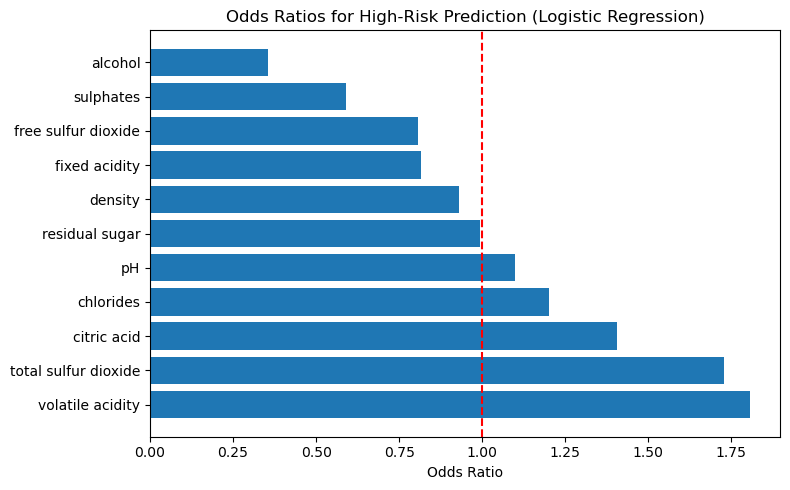

In [22]:
plt.figure(figsize=(8,5))
plt.barh(coef_df["feature"], coef_df["odds_ratio"])
plt.axvline(1, color="red", linestyle="--")
plt.xlabel("Odds Ratio")
plt.title("Odds Ratios for High-Risk Prediction (Logistic Regression)")
plt.tight_layout()
plt.show()


## Summary — Interpretability

- Logistic Regression allows direct interpretation via coefficients and odds ratios.
- The model identifies chemical variables that **increase or reduce the risk** of low quality.
- These insights support transparent decision-making and strengthen the credibility
  of the final risk calculator.


## 11. Probability Calibration

For a risk calculator, it is not enough to correctly rank wines by risk.
Predicted probabilities should be **well calibrated**, meaning:

> Among wines predicted to have a 70% risk, approximately 70% should actually be high risk.

Good calibration is essential for:
- trustworthy probability outputs
- decision-making thresholds
- communication with non-technical users


### Calibration approach

We evaluate calibration by:
- plotting a **calibration curve** (reliability diagram)
- computing the **Brier score** (mean squared error of probabilistic predictions)

If necessary, we apply **post-hoc calibration** using:
- sigmoid calibration (Platt scaling)
- or isotonic calibration



In [23]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss


### 11.1 Calibration of the logistic regression model (before adjustment)

We first evaluate the raw probability outputs of the logistic regression model.


Brier score (before calibration) — Validation: 0.16849352474750673


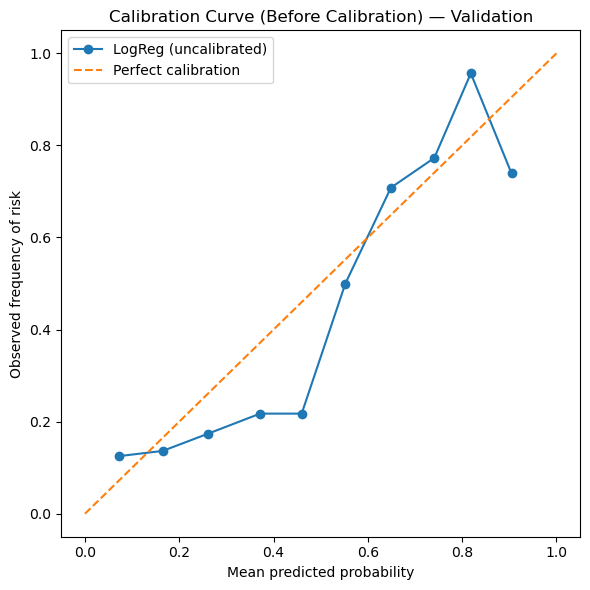

In [60]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Calibration curve (before calibration) — Validation
prob_true, prob_pred = calibration_curve(
    y_val, y_prob_val,
    n_bins=10,
    strategy="quantile"
)

brier_before = brier_score_loss(y_val, y_prob_val)
print("Brier score (before calibration) — Validation:", brier_before)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="LogReg (uncalibrated)")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed frequency of risk")
plt.title("Calibration Curve (Before Calibration) — Validation")
plt.legend()
plt.tight_layout()
plt.show()



### 11.2 Post-hoc Calibration

If calibration is imperfect, we apply post-hoc calibration using cross-validation.
This does not change the ranking performance (ROC-AUC) but improves probability reliability.


Brier score (after calibration) — Validation: 0.16761531202956667


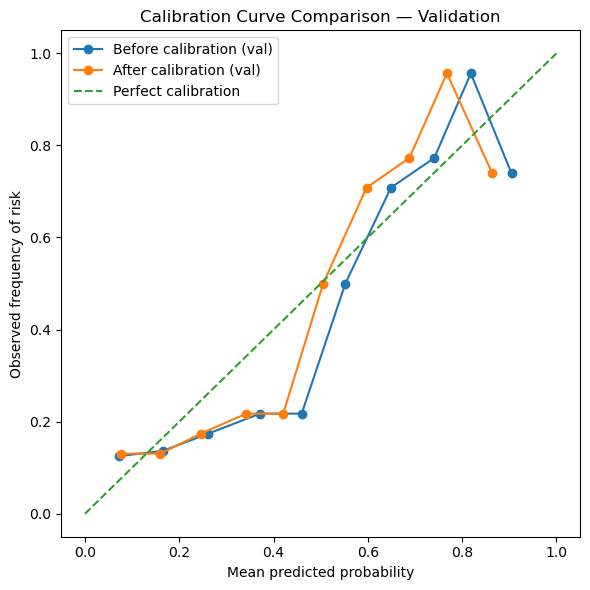

In [65]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from pathlib import Path
import matplotlib.pyplot as plt

# Define output directory (project root / reports / figures)
OUTPUT_DIR = Path("..") / "reports" / "figures"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Fit calibrated model on TRAIN only (internal CV within TRAIN)
calibrated_model = CalibratedClassifierCV(
    estimator=logreg_pipe,
    method="sigmoid",
    cv=5
)
calibrated_model.fit(X_train, y_train)

# Probabilities on VALIDATION (for calibration evaluation/decision)
y_prob_cal_val = calibrated_model.predict_proba(X_val)[:, 1]

brier_after_val = brier_score_loss(y_val, y_prob_cal_val)
print("Brier score (after calibration) — Validation:", brier_after_val)

# Calibration curve on VALIDATION
prob_true_cal_val, prob_pred_cal_val = calibration_curve(
    y_val,
    y_prob_cal_val,
    n_bins=10,
    strategy="quantile"
)

# "Before calibration" curve (also VALIDATION)
prob_true_val, prob_pred_val = calibration_curve(
    y_val,
    y_prob_val,
    n_bins=10,
    strategy="quantile"
)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred_val, prob_true_val, marker="o", label="Before calibration (val)")
plt.plot(prob_pred_cal_val, prob_true_cal_val, marker="o", label="After calibration (val)")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed frequency of risk")
plt.title("Calibration Curve Comparison — Validation")
plt.legend()
plt.tight_layout()

# Save figure
plt.savefig(
    OUTPUT_DIR / "calibration_curve_comparison_validation.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()




### Interpretation

- The calibration curve shows how closely predicted probabilities match observed risk frequencies.
- A lower Brier score indicates better calibrated probabilities.
- Post-hoc calibration improves probability reliability without altering the underlying model structure.

Given that this project outputs a **risk calculator**, calibrated probabilities are preferred.


### Final decision on probabilities

For the final risk calculator:
- We use the **calibrated probabilities** when reporting risk levels.
- The **decision threshold** selected earlier (recall-oriented) can be applied on calibrated probabilities.


In [29]:
# Save calibrated model for the risk calculator
from pathlib import Path
Path("../models").mkdir(exist_ok=True)

joblib.dump(calibrated_model, "../models/logreg_risk_pipeline_calibrated.joblib")


['../models/logreg_risk_pipeline_calibrated.joblib']

### Final calibration decision

- The original logistic regression model already showed good calibration.
- Post-hoc sigmoid calibration provided a small but consistent improvement.
- Given the objective of delivering a probability-based risk calculator,
  the calibrated model is retained for final deployment.


## Alcohol range filtering experiment

Based on the EDA results, wines above 12.5% alcohol represent a small and potentially
heterogeneous subset. In this experiment, we evaluate whether excluding these wines
improves the robustness of the risk model.


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.metrics import recall_score, roc_auc_score, average_precision_score

# Filter dataset
wine_quality_filtered = wine_quality[wine_quality["alcohol"] <= 12.5].copy()

wine_quality.shape, wine_quality_filtered.shape




((1143, 14), (1092, 14))

## Train-test split after filtering

The filtered dataset is split using the same strategy as the original model
to ensure a fair comparison.


In [38]:
X_filt = wine_quality_filtered[feature_cols]
y_filt = wine_quality_filtered["risk"]

X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(
    X_filt,
    y_filt,
    test_size=0.2,
    random_state=42,
    stratify=y_filt
)

## Model retraining on filtered data

The same Logistic Regression pipeline and configuration are retrained using
the filtered dataset. No hyperparameters or preprocessing steps are changed.


In [39]:
logreg_pipe_filt = clone(logreg_pipe)
logreg_pipe_filt.fit(X_train_filt, y_train_filt)



Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=42))])

## Evaluate filtered model

We evaluate performance on the filtered test set using the same metrics as the baseline,
focusing on recall for the high-risk class.


In [41]:
y_pred_filt = logreg_pipe_filt.predict(X_test_filt)
y_proba_filt = logreg_pipe_filt.predict_proba(X_test_filt)[:, 1]

metrics_filt = {
    "recall_risk": recall_score(y_test_filt, y_pred_filt),
    "roc_auc": roc_auc_score(y_test_filt, y_proba_filt),
    "pr_auc": average_precision_score(y_test_filt, y_proba_filt),
}

metrics_filt


{'recall_risk': 0.7281553398058253,
 'roc_auc': np.float64(0.8095078674255105),
 'pr_auc': np.float64(0.7865837054093544)}

## Baseline metrics (full dataset)

To compare fairly against the alcohol-filtered model, we compute the same metrics
for the baseline model trained on the full dataset and store them in a dictionary.


In [48]:
from sklearn.metrics import recall_score, roc_auc_score, average_precision_score

y_pred_full = logreg_pipe.predict(X_test)
y_proba_full = logreg_pipe.predict_proba(X_test)[:, 1]

metrics_full = {
    "recall_risk": recall_score(y_test, y_pred_full),
    "roc_auc": roc_auc_score(y_test, y_proba_full),
    "pr_auc": average_precision_score(y_test, y_proba_full),
}

metrics_full




{'recall_risk': 0.7523809523809524,
 'roc_auc': np.float64(0.8234254992319507),
 'pr_auc': np.float64(0.7845797006016246)}

## Metrics comparison (filtered vs full dataset)

We compare the alcohol-filtered model against the baseline model using identical metrics.
This isolates the impact of alcohol range filtering.


In [49]:
metrics_comparison = {
    "full_dataset": metrics_full,
    "filtered_alcohol_le_12_5": metrics_filt
}

metrics_comparison


{'full_dataset': {'recall_risk': 0.7523809523809524,
  'roc_auc': np.float64(0.8234254992319507),
  'pr_auc': np.float64(0.7845797006016246)},
 'filtered_alcohol_le_12_5': {'recall_risk': 0.7281553398058253,
  'roc_auc': np.float64(0.8095078674255105),
  'pr_auc': np.float64(0.7865837054093544)}}

- Full dataset:
  - Recall (high risk): 0.75
  - ROC-AUC: 0.82
  - PR-AUC: 0.78

- Filtered dataset (alcohol ≤ 12.5%):
  - Recall (high risk): 0.73
  - ROC-AUC: 0.81
  - PR-AUC: 0.79


### Interpretation

Filtering high-alcohol wines slightly reduces recall for the high-risk class,
which is the primary business objective. Although PR-AUC remains similar,
the decrease in recall suggests that alcohol range filtering does not provide
a clear benefit for this use case.

As a result, the final risk model is trained on the full dataset to minimize
false negatives and preserve sensitivity to low-quality wines.


# Model comparison (validation-driven)

In this section, we compare multiple candidate classifiers **in parallel** under the same data split:

- Train on **TRAIN**
- Choose the operating threshold using **VALIDATION** (policy-driven)
- Compare models on **VALIDATION** using:
  - Primary objective: **Recall (risk=1)** at the chosen threshold
  - Operational control: **Precision (risk=1)** at the chosen threshold
  - Supporting metrics: **ROC-AUC**, **PR-AUC**
  - Probability quality (optional): **Brier score**

**Important:** The **test set is not used** in this section. It is reserved for the final evaluation.


In [66]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score,
    precision_recall_curve, brier_score_loss
)


### Decision policy: threshold tuning for risk prevention

The model outputs probabilities `P(risk=1)`. We convert probabilities into decisions using a threshold.

Because False Negatives (missed risk) are costlier than False Positives (false alarms), we choose an operating threshold that achieves a **minimum target recall** for the High-Risk class (`risk=1`).

Policy used in this project:

- Target: **Recall(risk=1) ≥ TARGET_RECALL**
- Among thresholds meeting the target, choose the **lowest threshold** that still satisfies the target recall (conservative screening).


In [67]:
def threshold_for_target_recall(y_true, y_prob, target_recall=0.90):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    # thresholds has length n-1; precision/recall length n
    recall_thr = recall[:-1]
    precision_thr = precision[:-1]

    valid = np.where(recall_thr >= target_recall)[0]
    if len(valid) == 0:
        return None, None, None

    # Choose the lowest threshold that still meets target recall
    idx = valid[-1]
    return thresholds[idx], precision_thr[idx], recall_thr[idx]


### Candidate models

We evaluate three families of models:

- Logistic Regression (interpretable baseline)
- Random Forest (non-linear baseline)
- Gradient Boosting (strong general-purpose classifier)

All models are evaluated under the same split and threshold policy.


In [69]:
TARGET_RECALL = 0.90
RANDOM_STATE = 42

candidates = {
    "LogReg_balanced": Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            max_iter=2000,
            class_weight="balanced",
            random_state=RANDOM_STATE
        ))
    ]),
    "RandomForest_balanced": RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    "HistGB": HistGradientBoostingClassifier(
        max_depth=3,
        learning_rate=0.08,
        max_iter=400,
        random_state=RANDOM_STATE
    ),
}


### Train on TRAIN, tune threshold on VALIDATION, compare models on VALIDATION

For each model we report:

- Threshold selected from validation (based on target recall)
- Precision/Recall for `risk=1` at that threshold
- ROC-AUC and PR-AUC on validation
- Brier score on validation (optional probability quality indicator)


In [70]:
results = []

for name, model in candidates.items():
    model.fit(X_train, y_train)

    y_prob_val = model.predict_proba(X_val)[:, 1]

    roc_val = roc_auc_score(y_val, y_prob_val)
    pr_val = average_precision_score(y_val, y_prob_val)
    brier_val = brier_score_loss(y_val, y_prob_val)

    thr, prec_at_thr, rec_at_thr = threshold_for_target_recall(
        y_val, y_prob_val, target_recall=TARGET_RECALL
    )

    if thr is None:
        results.append({
            "model": name,
            "meets_target_recall": False,
            "selected_threshold": None,
            "precision_risk1": None,
            "recall_risk1": None,
            "roc_auc_val": roc_val,
            "pr_auc_val": pr_val,
            "brier_val": brier_val
        })
        continue

    y_pred_val = (y_prob_val >= thr).astype(int)
    report = classification_report(y_val, y_pred_val, output_dict=True, zero_division=0)

    results.append({
        "model": name,
        "meets_target_recall": True,
        "selected_threshold": float(thr),
        "precision_risk1": float(report["1"]["precision"]),
        "recall_risk1": float(report["1"]["recall"]),
        "f1_risk1": float(report["1"]["f1-score"]),
        "roc_auc_val": roc_val,
        "pr_auc_val": pr_val,
        "brier_val": brier_val
    })

results_df = pd.DataFrame(results).sort_values(
    by=["meets_target_recall", "recall_risk1", "precision_risk1", "pr_auc_val"],
    ascending=[False, False, False, False]
)

results_df


,model,meets_target_recall,selected_threshold,precision_risk1,recall_risk1,f1_risk1,roc_auc_val,pr_auc_val,brier_val
2,HistGB,True,0.288449,0.666667,0.903846,0.767347,0.823692,0.797765,0.180797
1,RandomForest_balanced,True,0.323780,0.652778,0.903846,0.758065,0.850923,0.815741,0.156994
0,LogReg_balanced,True,0.340223,0.598726,0.903846,0.720307,0.833000,0.775352,0.168494


### Winner selection rule (validation-driven)

We select the final model using validation results only:

1. The model must achieve **Recall(risk=1) ≥ TARGET_RECALL** on validation.
2. Among eligible models, choose the one with the **highest Precision(risk=1)** at the chosen operating threshold.
3. Use PR-AUC as a secondary tie-breaker.

This rule ensures the final model meets the prevention objective while controlling the operational burden of false alarms.


In [71]:
eligible = results_df[results_df["meets_target_recall"] == True].copy()

if eligible.empty:
    raise ValueError(
        "No model achieved the target recall on validation. "
        "Consider lowering TARGET_RECALL or revisiting model choices."
    )

winner = eligible.sort_values(
    by=["precision_risk1", "pr_auc_val"],
    ascending=[False, False]
).iloc[0]

WINNER_NAME = winner["model"]
WINNER_THRESHOLD = float(winner["selected_threshold"])

print("Winner model:", WINNER_NAME)
print("Frozen decision threshold (from validation):", WINNER_THRESHOLD)
winner


Winner model: HistGB
Frozen decision threshold (from validation): 0.2884485701273637


model                    HistGB
meets_target_recall        True
selected_threshold     0.288449
precision_risk1        0.666667
recall_risk1           0.903846
f1_risk1               0.767347
roc_auc_val            0.823692
pr_auc_val             0.797765
brier_val              0.180797
Name: 2, dtype: object

### Refit the winner on TRAIN+VALIDATION

Once the model family and threshold policy are fixed using validation, we refit the winner using **TRAIN+VALIDATION** to maximize available training data.

**Important:** The test set remains untouched until the final evaluation section.


In [72]:
winner_model = candidates[WINNER_NAME]
winner_model.fit(X_train_full, y_train_full)


HistGradientBoostingClassifier(learning_rate=0.08, max_depth=3, max_iter=400,
                               random_state=42)

# Final evaluation on TEST (holdout)

This section is executed once, at the end of the notebook.

- Use the **winner model** fitted on TRAIN+VALIDATION
- Apply the **frozen threshold** selected from validation
- Report final metrics on the **test set** (holdout)


In [73]:
y_prob_test = winner_model.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= WINNER_THRESHOLD).astype(int)

print("FINAL EVALUATION — TEST SET")
print("Winner:", WINNER_NAME)
print("Decision threshold (frozen from validation):", WINNER_THRESHOLD)
print()

print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_pred_test))
print()

print("Classification report (test):")
print(classification_report(y_test, y_pred_test, digits=3))
print()

print("ROC-AUC (test):", roc_auc_score(y_test, y_prob_test))
print("PR-AUC (test):", average_precision_score(y_test, y_prob_test))
print("Brier (test):", brier_score_loss(y_test, y_prob_test))


FINAL EVALUATION — TEST SET
Winner: HistGB
Decision threshold (frozen from validation): 0.2884485701273637

Confusion matrix (test):
[[77 47]
 [16 89]]

Classification report (test):
              precision    recall  f1-score   support

           0      0.828     0.621     0.710       124
           1      0.654     0.848     0.739       105

    accuracy                          0.725       229
   macro avg      0.741     0.734     0.724       229
weighted avg      0.748     0.725     0.723       229


ROC-AUC (test): 0.8324884792626728
PR-AUC (test): 0.8109592155035077
Brier (test): 0.16912337672847294


## Final evaluation summary

The final model selected was a Histogram Gradient Boosting classifier, using a decision threshold of 0.288 determined on the validation set to achieve a target recall for high-risk wines.

On the held-out test set, the model achieves:
- Recall (risk = 1): 0.85
- Precision (risk = 1): 0.65
- ROC-AUC: 0.83
- PR-AUC: 0.81

This confirms that the model generalizes well and successfully prioritizes the detection of low-quality (high-risk) wines, while maintaining a manageable rate of false positives. The results are consistent with the preventive, conservative objective defined in the risk framework.


# The Winner - Histogram Gradient Boosting model
Multiple models were evaluated under the same validation-driven threshold policy.
While logistic regression provided a strong interpretable baseline, the Histogram Gradient Boosting model achieved a better precision–recall trade-off while meeting the same recall target for high-risk wines.
Therefore, HistGB was selected as the final model.

In [77]:
import joblib
from pathlib import Path

Path("../models").mkdir(exist_ok=True)

# Save final HistGB model (winner)
joblib.dump(
    winner_model,
    "../models/histgb_risk_model.joblib"
)

# Save frozen threshold (keep as single source of truth)
joblib.dump(
    {
        "histgb_frozen_threshold": 0.288,
        "recall_target": 0.85,
        "notes": "Threshold tuned on validation only and frozen before test."
    },
    "../models/risk_thresholds.joblib"
)

"Saved: histgb_risk_model.joblib + updated risk_thresholds.joblib"


'Saved: histgb_risk_model.joblib + updated risk_thresholds.joblib'